In [2]:
pip install -U textblob

Requirement already up-to-date: textblob in /Users/ow/opt/anaconda3/lib/python3.7/site-packages (0.15.3)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import collections
from collections import Counter
import pandas as pd
from sqlalchemy import create_engine
import json
import psycopg2
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score

In [2]:
connection_string = psycopg2.connect(host="mypostgresdb.cnm9emj4w74o.us-east-2.rds.amazonaws.com", port = 5432, database="project3", user="rootlh", password="password")

In [3]:
df = pd.read_sql_query('select * from post_info', con=connection_string)
df.head()

,type,posts
0,INTJ,'https://www.youtube.com/watch?v=8IEQpfA528M ...
1,INFP,"'It's one of my daily 'music doodles', one min..."
2,INFP,'NO. But I have dyscalculia. :X|||I've learned...
3,ISTP,"'288970 It's been a while, guys. Also I bleach..."
4,INFP,'29 and still have it. Never had a girlfriend....


In [4]:
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split()))
df['question_per_comment'] = df['posts'].apply(lambda x: x.count('?'))
df['excl_per_comment'] = df['posts'].apply(lambda x: x.count('!'))
df['upper_case'] = df['posts'].str.findall(r'[A-Z]').str.len()
# df['adj'] = df['posts'].str.findall(r'[A-Z]').str.len()
df[['polarity', 'subjectivity']] = df['posts'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
# df['emojis'] = df['posts'].str.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]').str.len()
df['ellipsis_per_comment'] = df['posts'].apply(lambda x: x.count('...'))

print(df.head(10))

   type                                              posts  words_per_comment  \
0  INTJ  'https://www.youtube.com/watch?v=8IEQpfA528M  ...               1143   
1  INFP  'It's one of my daily 'music doodles', one min...                873   
2  INFP  'NO. But I have dyscalculia. :X|||I've learned...                665   
3  ISTP  '288970 It's been a while, guys. Also I bleach...                545   
4  INFP  '29 and still have it. Never had a girlfriend....               1399   
5  INFJ  'It gets to be pretty obvious the lifestyle di...               1049   
6  INTP  'I used to find this difficult until I realize...               1190   
7  INTJ  '1. ENTJs - Without fail my favorite people.  ...               1694   
8  ENFP  'Can I just say I'm so glad and thankful that ...               1314   
9  ESFP  'No I'm not, you go home!|||Farnsworth: ENTP F...               1090   

   question_per_comment  excl_per_comment  upper_case  polarity  subjectivity  \
0                    34    

In [5]:
df.describe()

,words_per_comment,question_per_comment,excl_per_comment,upper_case,polarity,subjectivity,ellipsis_per_comment
count,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000
mean,1226.241499,10.730951,8.454294,282.125072,0.125152,0.535031,33.124265
std,311.210544,6.994926,11.610943,94.664190,0.060422,0.045603,14.972922
min,4.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000
25%,1046.500000,6.000000,2.000000,224.000000,0.087922,0.505834,23.000000
50%,1278.000000,10.000000,5.000000,278.000000,0.122788,0.533764,33.000000
75%,1457.000000,14.000000,11.000000,333.000000,0.159827,0.562812,41.000000
max,1881.000000,121.000000,219.000000,940.000000,0.558087,1.000000,196.000000


In [6]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}

df['I-E'] = df['type'].astype(str).str[0]
df['I-E'] = df['I-E'].map(map1)

df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)

df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)

df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)

print(df.head(10))

   type                                              posts  words_per_comment  \
0  INTJ  'https://www.youtube.com/watch?v=8IEQpfA528M  ...               1143   
1  INFP  'It's one of my daily 'music doodles', one min...                873   
2  INFP  'NO. But I have dyscalculia. :X|||I've learned...                665   
3  ISTP  '288970 It's been a while, guys. Also I bleach...                545   
4  INFP  '29 and still have it. Never had a girlfriend....               1399   
5  INFJ  'It gets to be pretty obvious the lifestyle di...               1049   
6  INTP  'I used to find this difficult until I realize...               1190   
7  INTJ  '1. ENTJs - Without fail my favorite people.  ...               1694   
8  ENFP  'Can I just say I'm so glad and thankful that ...               1314   
9  ESFP  'No I'm not, you go home!|||Farnsworth: ENTP F...               1090   

   question_per_comment  excl_per_comment  upper_case  polarity  subjectivity  \
0                    34    

In [7]:
X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values

(8675,)
(8675, 7)
k: 1, Train/Test Score: 1.000/0.656
k: 3, Train/Test Score: 0.830/0.717
k: 5, Train/Test Score: 0.792/0.730
k: 7, Train/Test Score: 0.783/0.749
k: 9, Train/Test Score: 0.779/0.757
k: 11, Train/Test Score: 0.778/0.764
k: 13, Train/Test Score: 0.775/0.767
k: 15, Train/Test Score: 0.771/0.770
k: 17, Train/Test Score: 0.772/0.770
k: 19, Train/Test Score: 0.772/0.771


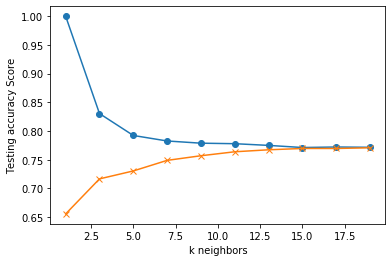

0.716589861751152

In [10]:
# Introvert vs. Extrovert

y = df['I-E'].values

print(y.shape)
print(X.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

(8675,)
(8675, 7)
k: 1, Train/Test Score: 1.000/0.767
k: 3, Train/Test Score: 0.881/0.839
k: 5, Train/Test Score: 0.863/0.859
k: 7, Train/Test Score: 0.861/0.870
k: 9, Train/Test Score: 0.860/0.878
k: 11, Train/Test Score: 0.860/0.880
k: 13, Train/Test Score: 0.860/0.879
k: 15, Train/Test Score: 0.860/0.879
k: 17, Train/Test Score: 0.860/0.880
k: 19, Train/Test Score: 0.860/0.880


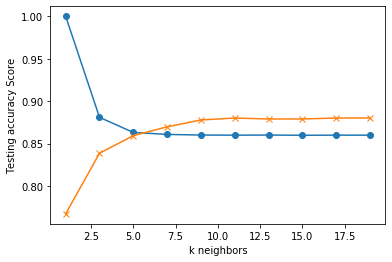

0.8387096774193549

In [12]:
#Intuitive vs. Sensing

y = df['N-S'].values

print(y.shape)
print(X.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

(8675,)
(8675, 7)
k: 1, Train/Test Score: 1.000/0.523
k: 3, Train/Test Score: 0.769/0.532
k: 5, Train/Test Score: 0.715/0.545
k: 7, Train/Test Score: 0.689/0.535
k: 9, Train/Test Score: 0.672/0.550
k: 11, Train/Test Score: 0.656/0.560
k: 13, Train/Test Score: 0.649/0.560
k: 15, Train/Test Score: 0.650/0.553
k: 17, Train/Test Score: 0.646/0.561
k: 19, Train/Test Score: 0.641/0.546


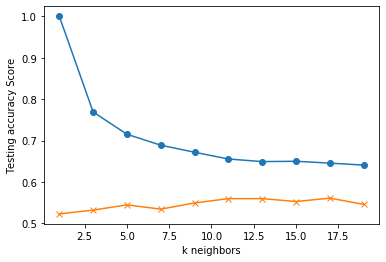

0.532258064516129

In [11]:
# Thinking vs. Feeling

y = df['T-F'].values

print(y.shape)
print(X.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

(8675,)
(8675, 7)
k: 1, Train/Test Score: 1.000/0.523
k: 3, Train/Test Score: 0.762/0.518
k: 5, Train/Test Score: 0.704/0.522
k: 7, Train/Test Score: 0.678/0.526
k: 9, Train/Test Score: 0.660/0.548
k: 11, Train/Test Score: 0.647/0.563
k: 13, Train/Test Score: 0.643/0.561
k: 15, Train/Test Score: 0.640/0.554
k: 17, Train/Test Score: 0.630/0.573
k: 19, Train/Test Score: 0.631/0.568


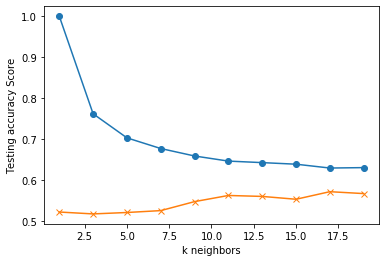

0.5184331797235023

In [12]:
# Judging vs. Perceiving

y = df['J-P'].values

print(y.shape)
print(X.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

(8675,)
(8675, 7)
k: 1, Train/Test Score: 1.000/0.139
k: 3, Train/Test Score: 0.472/0.132
k: 5, Train/Test Score: 0.398/0.164
k: 7, Train/Test Score: 0.361/0.169
k: 9, Train/Test Score: 0.341/0.171
k: 11, Train/Test Score: 0.321/0.182
k: 13, Train/Test Score: 0.310/0.175
k: 15, Train/Test Score: 0.301/0.192
k: 17, Train/Test Score: 0.295/0.206
k: 19, Train/Test Score: 0.287/0.191


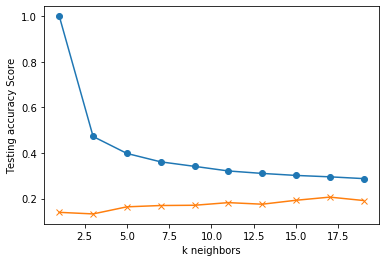

0.13248847926267282

In [13]:
#Overall Score

y = df['type'].values

print(y.shape)
print(X.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)